# Earthquake
Time:
2020-09-06 10:16:58 (UTC+09:00)
Location:
30.336°S 71.564°W
Country:
Chile
Depth:
30.7 km

In [1]:
import obspy
from obspy import read
from obspy.clients.fdsn import Client
client = Client("IRIS")
from obspy import UTCDateTime
import matplotlib.pyplot as plt
%matplotlib inline

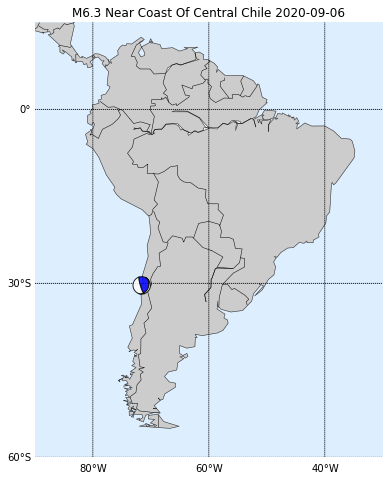

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from obspy.imaging.beachball import beach
from obspy.imaging.beachball import beachball


# Set up a custom basemap, example is taken from basemap users' manual
fig, ax = plt.subplots(figsize=(8,8))

# Control the position of the square. Give the coordinate of 2 corners
m=Basemap(llcrnrlon=-90, llcrnrlat=-60,urcrnrlon=-30,urcrnrlat=15)

# Draw the components of the map
m.drawcoastlines(linewidth=0.5, color='black')
m.fillcontinents()
m.drawcountries()
m.drawmapboundary(fill_color='#ddeeff', linewidth=0)
# m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
# m.fillcontinents(color='brown', alpha=0.6, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")

# # 5度ごとに緯度線を描く
m.drawparallels(np.arange(-90., 120., 30.), labels=[True, False, False, True])

# 5度ごとに経度線を描く
m.drawmeridians(np.arange(0., 420., 20.), labels = [False, True, False, True], fontsize=10)


x, y = m(-71.564, -30.336)
focmecs = [ 163, 76, 78]
# we need to attach the basemap object to the figure, so that obspy knows about
# it and reuses it
fig.bmap = m

# now let's plot some data on the custom basemap:
ax = plt.gca()
b = beach(focmecs, xy=(x, y), width=3, linewidth=1, alpha=0.85)
b.set_zorder(10)
ax.add_collection(b)
ax.set_title("M6.3 Near Coast Of Central Chile 2020-09-06")

plt.savefig('beachball96.png', bbox_inches='tight')
plt.show()

# Downloading data from HP

In [3]:
time = UTCDateTime("2020-09-06T01:16:58 ")
starttime = time - 60*1
endtime = time + 60*5

net = "IU"
sta = "LCO"
loc = "00"
chan = "BH*"

st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)

print(st)



3 Trace(s) in Stream:
IU.LCO.00.BH1 | 2020-09-06T01:15:58.019538Z - 2020-09-06T01:21:57.969538Z | 20.0 Hz, 7200 samples
IU.LCO.00.BH2 | 2020-09-06T01:15:58.019538Z - 2020-09-06T01:21:57.969538Z | 20.0 Hz, 7200 samples
IU.LCO.00.BHZ | 2020-09-06T01:15:58.019538Z - 2020-09-06T01:21:57.969538Z | 20.0 Hz, 7200 samples


# Removing instrument response

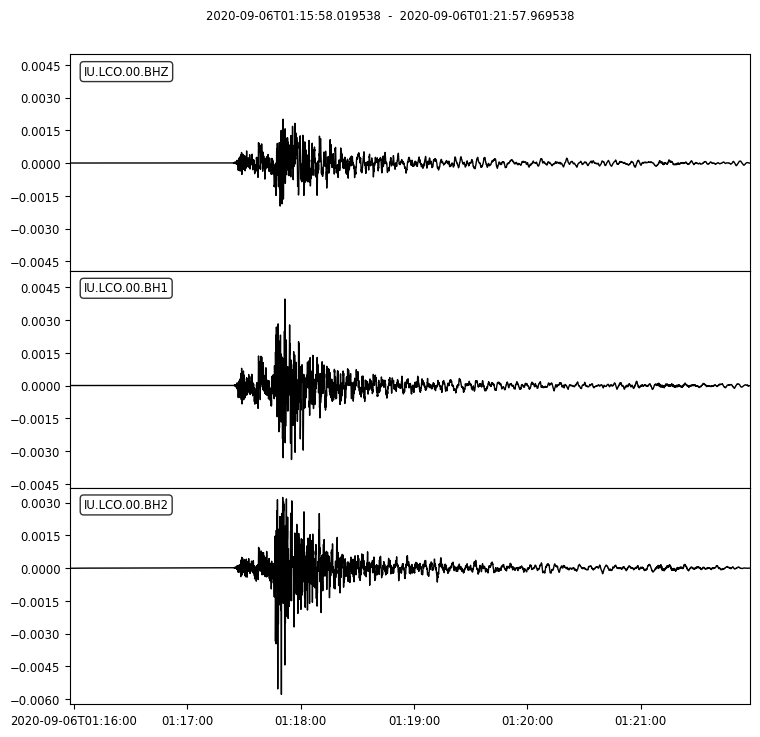

In [4]:

st_rem = st.copy()
st_rem.remove_response(output = 'VEL')  #we can choose ACC(m/s/s) or DISP(m)
st_rem.plot();

# Writing downloaded data to a file

In [5]:
filename = net + sta + '_' + chan + '.mseed'
print(filename)
st_rem.write(filename, format='MSEED')


IULCO_BH*.mseed


/Users/samaneharzpeima/opt/anaconda3/lib/python3.8/site-packages/obspy/io/mseed/core.py:790: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


now we can read it.

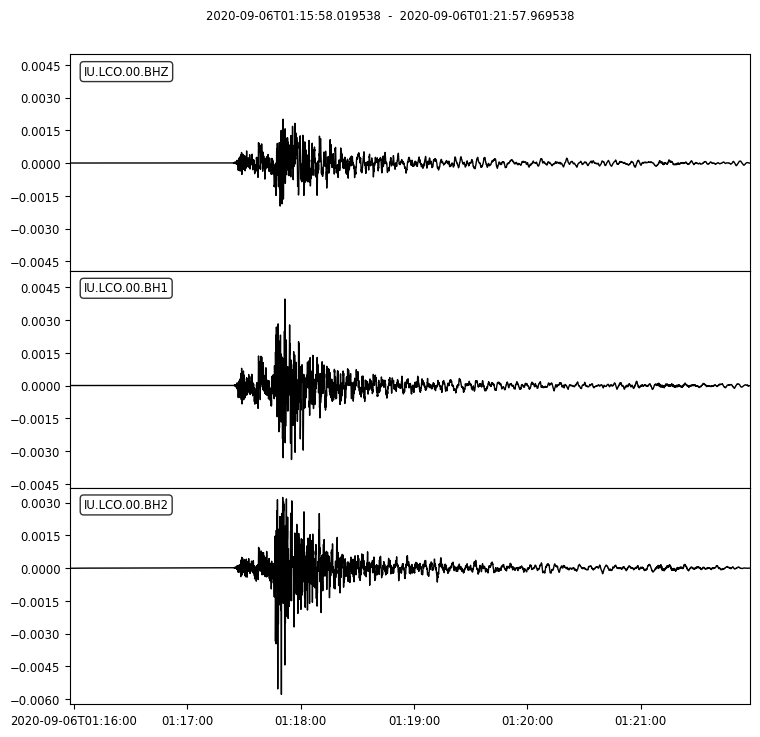

In [6]:
from obspy import read
st = read(filename)
st.plot();

# Filtering

In [7]:
st_filt = st.copy()
# st_filt = st_filt.filter("lowpass", freq=0.05, corners=2)
st_filt = st_filt.filter("bandpass", freqmin=1.0, freqmax=20.0)

/Users/samaneharzpeima/opt/anaconda3/lib/python3.8/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (20.0) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)


# Resampling

In [8]:
st_filt[0].stats.sampling_rate

20.0

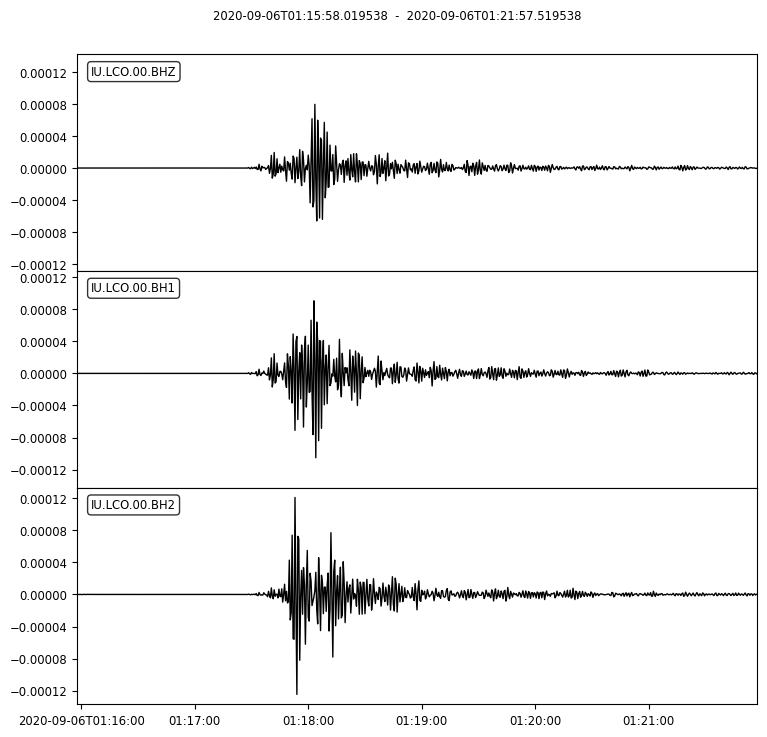

In [9]:
st_dec = st_filt.copy()

st_dec.decimate(10)

st_dec.plot();

# Spectogram

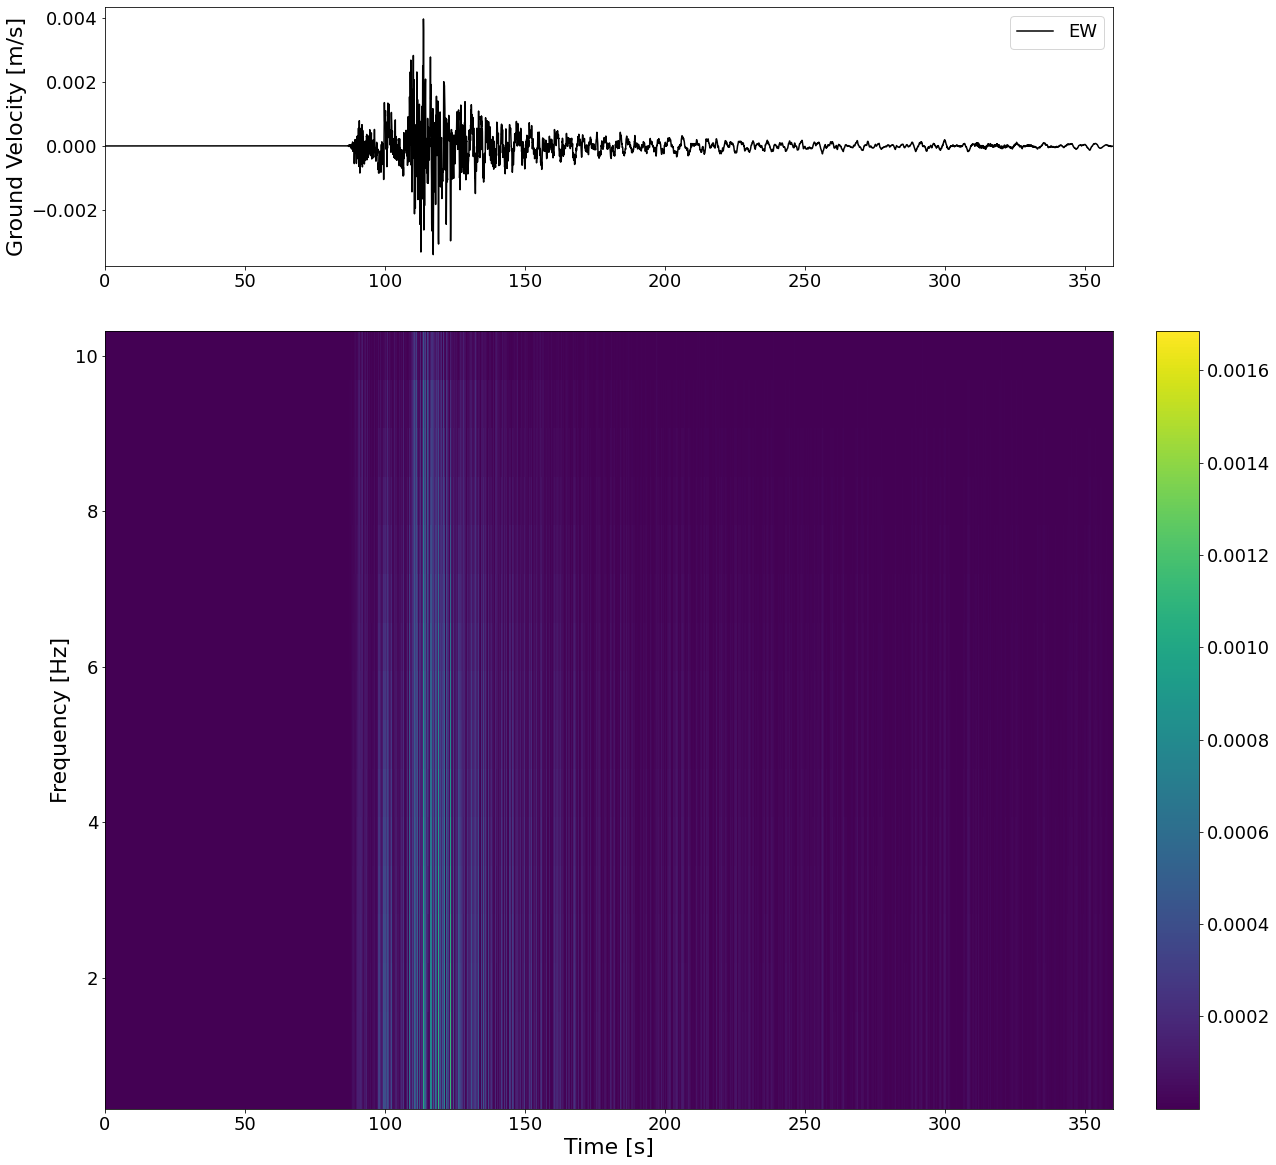

In [10]:
from obspy.imaging.spectrogram import spectrogram 
fig = plt.figure(figsize = (20,18)) 

plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)

ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height] 
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1) 
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6]) 

# #make time vector 
# # t = np.arange(spl1[0].stats.npts)/spl1[0].stats.sampling_rate 

#plot waveform (top subfigure)  
ax1.plot(st[0].times(), st[0].data, label = "EW",color = 'k') 
ax1.set_xlim(0,350)
ax1.legend(fontsize=18)


xlabel = 'Time [s]'
ylabel1 = "Ground Velocity [m/s]"


# 各要素の設定をおこなうsetコマンド
# ax1.set_xlabel(xlabel,fontsize=22)
ax1.set_ylabel(ylabel1,fontsize=22)

# #plot spectrogram (bottom subfigure) 
spl2 = st[0] 
fig = spl2.spectrogram( show=False, axes=ax2) 


ylabel2 = 'Frequency [Hz]'

ax2.set_xlabel(xlabel,fontsize=22)
ax2.set_ylabel(ylabel2,fontsize=22)



mappable = ax2.images[0] 
plt.colorbar(mappable=mappable, cax=ax3) 

plt.savefig('spectogram96.png', bbox_inches='tight')
plt.show()

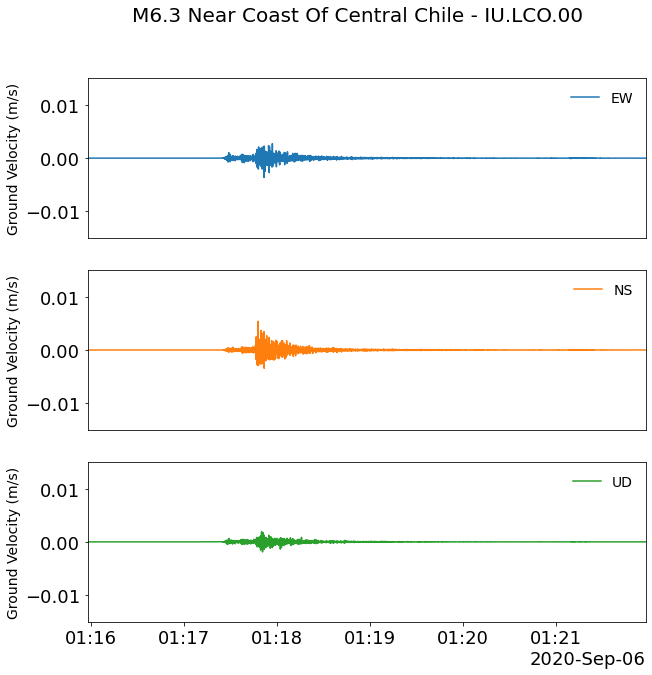

In [11]:
import matplotlib.dates as mdates

EW_data = st_filt[0].data
EW_times = st_filt[0].times(type = 'matplotlib')

NS_data = st_filt[1].data
NS_times = st_filt[1].times(type = 'matplotlib')

UD_data = st_filt[2].data
UD_times = st_filt[2].times(type = 'matplotlib')


fig = plt.figure(figsize = (10,10))
plt.suptitle("M6.3 Near Coast Of Central Chile - " + net + "." + sta + "." + loc, fontsize = 20)

ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.plot(EW_times, EW_data, label = "EW", color = 'C0')
# ax1.axes.xaxis.set_ticklabels([])
ax1.axes.xaxis.set_visible(False)
ax1.set_ylabel("Ground Velocity (m/s)", fontsize=14)
ax1.set_xlim(EW_times[0], EW_times[-1])
ax1.set_ylim(-0.015,0.015)
ax1.legend(loc=0, frameon=False, fontsize=14)
locator = ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

ax2.plot(NS_times, NS_data, label = "NS", color = 'C1')
# ax2.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_visible(False)
ax2.set_ylabel("Ground Velocity (m/s)", fontsize=14)
ax2.set_xlim(NS_times[0], NS_times[-1])
ax2.set_ylim(-0.015,0.015)  #ax2.set_ylim(-0.004,0.004)
ax2.legend(loc=0, frameon=False, fontsize=14)
locator = ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

ax3.plot(UD_times, UD_data, label = "UD", color = 'C2')
# ax1.set_xlabel("Freqency [Hz]")
# ax1.axes.xaxis.set_ticklabels([])
ax3.set_ylabel("Ground Velocity (m/s)", fontsize=14)
ax3.set_xlim(UD_times[0], UD_times[-1])
ax3.set_ylim(-0.015,0.015)
ax3.legend(loc=0, frameon=False, fontsize=14)
locator = ax3.xaxis.set_major_locator(mdates.AutoDateLocator())
ax3.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.savefig('3components96.png', bbox_inches='tight')
plt.show()

Seismic waves contain various frequency (period) components. The spectrum of seismic waves is obtained by decomposing these into frequency components.

$$F(\omega) = \int_{-\infty}^{\infty} f(t) e^{i \omega t} dt)$$

The real part on the left side is the spectrum amplitude, and the imaginary part is the phase.


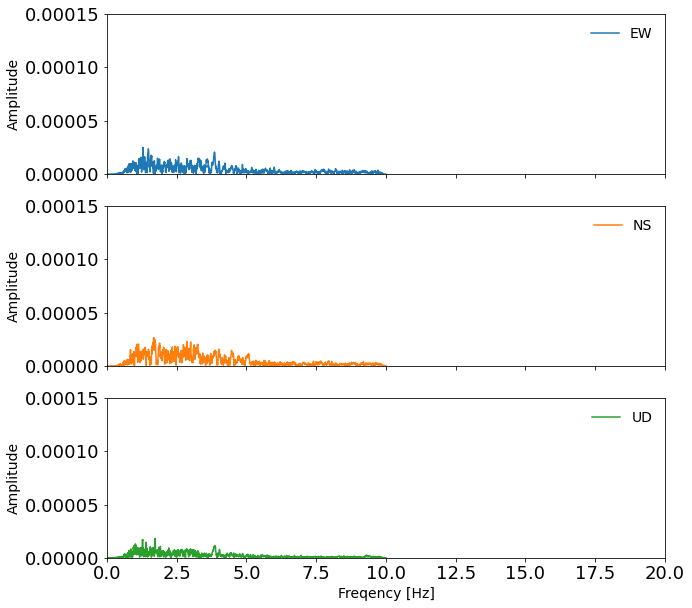

In [12]:
from scipy.fftpack import fft, ifft
import numpy as np
import matplotlib.pyplot as plt

N = st[0].stats.npts  # サンプル数
dt = (st_filt[0].stats.delta)  # サンプリング周期 [s]
freq = np.fft.fftfreq(N, d=dt)   # 周波数


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

# fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, figsize=(10,10), sharex=True)


x1 = EW_data
F1 = np.fft.fft(x1)  # 変換結果   # 振幅
Amp1 = np.abs(F1/(N/2))
ax1.plot(freq[1:int(N/2)], Amp1[1:int(N/2)],label = 'EW', color = 'C0')
# ax1.set_xlabel("Freqency [Hz]")
ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylabel("Amplitude", fontsize=14)
ax1.set_xlim(0,20)
ax1.set_ylim(0,15e-5)
ax1.legend(loc=0, frameon=False, fontsize=14)




x2 = NS_data
F2 = np.fft.fft(x2)  # 変換結果   # 振幅
Amp2 = np.abs(F2/(N/2))
ax2.plot(freq[1:int(N/2)], Amp2[1:int(N/2)],label = 'NS', color = 'C1')
# ax2.set_xlabel("Freqency [Hz]")
ax2.axes.xaxis.set_ticklabels([])
ax2.set_ylabel("Amplitude", fontsize=14)
ax2.set_xlim(0,20)
ax2.set_ylim(0,15e-5)
ax2.legend(loc=0, frameon=False, fontsize=14)


x3 = UD_data
F3 = np.fft.fft(x3)  # 変換結果   # 振幅
Amp3 = np.abs(F3/(N/2))
ax3.plot(freq[1:int(N/2)], Amp3[1:int(N/2)],label = 'UD', color = 'C2')
ax3.set_xlabel("Freqency [Hz]", fontsize=14)
ax3.set_ylabel("Amplitude", fontsize=14)
ax3.set_xlim(0,20)
ax3.set_ylim(0,15e-5)
ax3.legend(loc=0, frameon=False, fontsize=14)

# set labels
# plt.setp(ax3, xlabel='Freqency [Hz]')
# plt.setp([ax1,ax2,ax3], ylabel='Amplitude')

plt.savefig('freqarea96.png', bbox_inches='tight')
plt.show()


The spectrum of the observed wave is obtained by Fourier transforming. The seismograph characteristics and the influence of the seismic wave propagation process can be corrected to obtain the “source spectrum”. This “source spectrum” shows the rupture process of the source fault in the frequency domain.

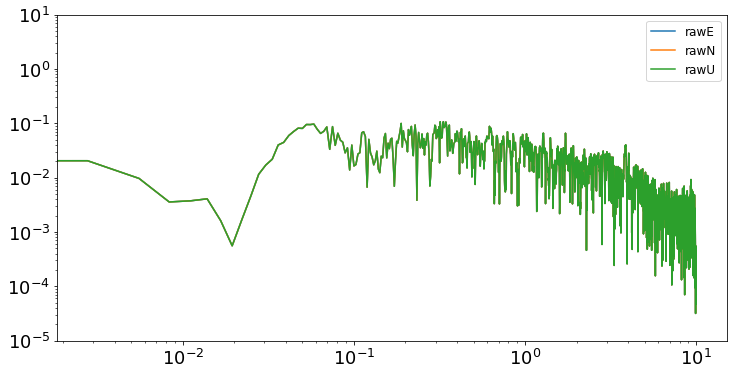

In [13]:
import obspy
import obspy.signal.util
import numpy as np
from numpy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt

tr = st[0]
tr = st[1]
tr = st[2]

spec, freqs = rfft(tr.data), rfftfreq(tr.stats.npts, tr.stats.delta)

plt.figure(figsize=(12, 6))
plt.loglog(freqs, np.abs(spec), label="rawE", color="C0")
plt.loglog(freqs, np.abs(spec), label="rawN", color="C1")
plt.loglog(freqs, np.abs(spec), label="rawU", color="C2")
plt.legend(loc=0, frameon=True, fontsize=12)
plt.ylim((1e-5,1e+1))

plt.savefig('sourcespectrum96.png', bbox_inches='tight')
plt.show()

# Seismicity Rate in this Area in a week

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import pandas as pd
import pickle

plt.xkcd()

from obspy.clients.fdsn import Client
c = Client("IRIS")
from obspy.core import UTCDateTime

try:
    cat = pickle.load(open( "save.p", "rb" ))

except:
    cat = c.get_events(  minlat=-40,maxlat=-26,minlon=-74,maxlon=-69,
                    starttime=UTCDateTime("2020-09-01"),endtime=UTCDateTime("2020-09-07"),
                    minmag=0.0)
    pickle.dump(cat,open( "save.p", "wb" ))

times = []
lats = []
lons = []
deps = []
magnitudes = []
magnitudestype = []

for event in cat:
    if len(event.origins) != 0 and len(event.magnitudes) != 0:
        times.append(event.origins[0].time.datetime)
        lats.append(event.origins[0].latitude)
        lons.append(event.origins[0].longitude)
        deps.append(event.origins[0].depth/1000)
        magnitudes.append(event.magnitudes[0].mag)
        magnitudestype.append(event.magnitudes[0].magnitude_type )

df = pd.DataFrame({'lat':lats,'lon':lons,'depth':deps,
                   'mag':magnitudes,'type':magnitudestype}, 
                  index = times)

pd.options.display.float_format = '{:.1f}'.format
df

,lat,lon,depth,mag,type
2020-09-06 11:21:00.542,-28.0,-71.4,19.0,4.7,Mwr
2020-09-06 01:16:58.930,-30.3,-71.6,30.7,6.3,Mww
2020-09-05 17:37:52.427,-27.9,-71.7,10.6,4.0,Mwr
2020-09-05 06:39:41.461,-27.9,-71.6,10.4,4.8,Mwr
2020-09-04 13:23:21.628,-33.4,-71.3,46.7,3.9,ML
2020-09-04 06:06:34.649,-27.8,-71.4,17.8,4.0,Mwr
2020-09-04 02:57:52.257,-27.8,-71.6,10.0,4.2,Mwr
2020-09-04 01:13:17.164,-27.9,-71.5,10.0,4.4,Mwr
2020-09-03 22:49:46.006,-27.8,-71.6,14.5,4.4,Mwr
2020-09-03 15:36:11.207,-27.9,-71.8,9.2,4.0,Mwr


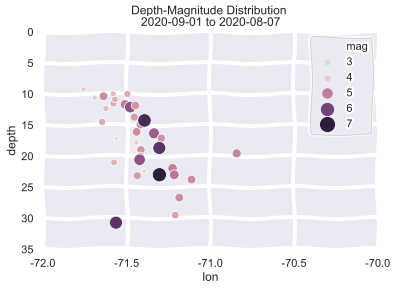

In [15]:
from matplotlib.ticker import *

sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":10}) 

sns.set(color_codes=True)
ax=sns.scatterplot(data=df, x='lon', y='depth',size='mag', sizes=(20,200), hue='mag')
ax.set(ylim=(0,35))
ax.set(xlim=(-72,-70))
ax.set_title('Depth-Magnitude Distribution \n 2020-09-01 to 2020-08-07 ')
ax.invert_yaxis()
ax.xaxis.set_major_locator(MultipleLocator(.5))
plt.savefig('depth-mag dist',dpi=150)